# Indexing Scholarly Research Articles

Pipeline for creating and analysing scientific networks. The first phase is downloading the publicly available data. The second phase is to extract the data of the provided date range. The third phase is to filter the cited and citing nodes of DOIs. The fourth phase is to load the data as scientific networks. Finally, the last phase is to index the articles.
Publicly available dumps of both Crossref and COCI are free for use. Other than downloading the data, it is also needed to have seed DOIs. The steps are not dependent on each other but subsequent phases depend on data being placed in correct directories.

In [1]:
%load_ext autoreload
%autoreload 2

import Extract, Transform, Load, Index

C:\ProgramData\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Input

In [3]:
usecase = ['BIB1', 'BIB2', 'IND1', 'IND2' ,'COM']
x = []
usecaseDIR=[]
'''
BIB1: Bibliometric Study with seminal seed DOIs
BIB2: Bibliometric Study with random seed DOIs
IND1: Indicators Review with seminal seed DOIs
IND2: Indicators Review with random seed DOIs
COM: Community Review with random seed DOIs
'''
randomFlag = False
#Input citation cascade details / total ego levels 
totalLevels = 3

# Input DASK configurations
physicalCores = 8
virtualPerCore = 2

#Input data directory to use
for i in range(len(usecase)):
    DataDir = "../DATA/"
    usecaseDIR = "../"+usecase[i]+"/"
    x.append(usecaseDIR)
    path_to_COCI = DataDir+"COCI/csv/*.csv"


print(x)



['../BIB1/', '../BIB2/', '../IND1/', '../IND2/', '../COM/']


# Extraction Phase

This phase concerns extracting the metadata for an input date range. Only the past decade is considered to give equal chance to early career researchers. It is also needed to curtail processing all the data. The date range should be selected based on the available processing and RAM. To process large files, DASK is used for out-of-core processing. It can be scaled to multi-node clusters. The steps are not dependent on each other but subsequent phases depend on relevant data being extracted that can fit in memory.


In [19]:
#Date range
#print(usecase)
for i in range(len(usecase)):
    if usecase=="BIB1":
        start_year = 2010
        end_year = 2020
        print(usecase)
        print(start_year)
        print(end_year)
    elif usecase=="IND1":
        start_year = 1985
        end_year = 2015
        print(usecase)
        print(start_year)
        print(end_year)
    elif usecase[0:3]=="COM":
        start_year = 1985
        end_year = 2015
        print(usecase)
        print(start_year)
        print(end_year)
    else:
        start_year = 1985
        end_year = 2020
#         print(usecase)
#         print(start_year)
#         print(end_year)






In [21]:
#Directory sub folders path
path_to_crossref_parquet = DataDir+"Crossref/"+str(start_year)+"parquet"+str(end_year)+"/"
metadataFull = DataDir+"Crossref/"+str(start_year)+"metadata"+str(end_year)+".pkl"
citNetFull = DataDir+"COCI/"+str(start_year)+"COCI"+str(end_year)+".pkl"

CrossrefColsDF = ['DOI','Title','Venue','Authors','Year']

path_to_COCI_parquet = DataDir+"COCI/"+str(start_year)+"parquet"+str(end_year)+"/"
COCIColsDDF=['citing','cited','creation', 'oci']

#### Extract metadata for the provided date range in parquet format
This step relates to creating a parquet binary file format for Crossref JSON. It is needed for the fast processing of subsequent steps. For a date range 2010-2020 this requires around 15 GB of space. This is a compute-heavy step and takes approximately five hours to complete. It uses a DASK Bag to read the JSON files.

In [5]:
%time Extract.convertCrossrefJSONDumpToParquetDDF(path_to_crossref, path_to_crossref_parquet, physicalCores, virtualPerCore, start_year, end_year)

<Client: 'tcp://127.0.0.1:35242' processes=8 threads=16, memory=67.95 GiB>


D:\Profiles\Users\bilal.hayat\AppData\Roaming\Python\Python37\site-packages\distributed\worker.py:3886: UserWarning: Large object of size 2.18 MiB detected in task graph: 
  [["('to-parquet-9998bcba7478bc135dc9482c06961d63', ... 10parquet2020']
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)
distributed.nanny - WARNING - Worker process still alive after 4 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 4 seconds, killing


Wall time: 5h 1min 43s


#### Convert parquet to pickle format
This step relates to extracting relevant columns of metadata to pickle format. It is a memory-intensive step and takes approximately an hour to complete. It creates a 16 GB binary file that is used by subsequent phases.


In [5]:
%time Extract.convertParquetToPickleDF (path_to_crossref_parquet, CrossrefColsDF, metadataFull)

OSError: [Errno 22] Invalid argument: '../DATA/Crossref/1985parquet2020/'

#### Extract COCI for the provided date range in parquet format
This step relates to creating a parquet binary file format for COCI. It is needed for the fast processing of subsequent steps. For a date range from the year 2010 to the year 2020, this requires around 45 GB of space. This is a compute-heavy step and takes approximately three hours to complete. It uses a DASK Dataframe to read the CSV files.

In [13]:
%time Extract.convertCOCIDumpToParquetDDF (path_to_COCI, COCIColsDDF, physicalCores, virtualPerCore, path_to_COCI_parquet, start_year, end_year)

C:\ProgramData\Anaconda3\lib\site-packages\distributed\node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54267 instead
  f"Port {expected} is already in use.\n"


<Client: 'tcp://127.0.0.1:54270' processes=8 threads=16>


IndexError: list index out of range

# Transformation Phase

This phase concerns transforming the data acquired to a format that is suitable for loading to the network processing library. The steps are dependent on their preceding steps. This phases takes around 2 hours to complete.

In [22]:
print(x)
for i in range(len(usecase)):
    DOIPkl = x[i]+"DOIs.pkl"
    DOItestPkl = x[i]+"DOItest.pkl"
    refDf = x[i]+"refDf.pkl"

    print(DOIPkl)
    print(DOItestPkl)

['../BIB1/', '../BIB2/', '../IND1/', '../IND2/', '../COM/']
../BIB1/DOIs.pkl
../BIB1/DOItest.pkl
../BIB2/DOIs.pkl
../BIB2/DOItest.pkl
../IND1/DOIs.pkl
../IND1/DOItest.pkl
../IND2/DOIs.pkl
../IND2/DOItest.pkl
../COM/DOIs.pkl
../COM/DOItest.pkl


In [23]:
#reference DOI or URL for comparisons 
if usecase[0:3]=="usecase":
    refDOI = '10.1016/j.physrep.2009.11.002' #for COM
else:
    refDOI = '10.1016/j.joi.2016.02.007' #for IND

refURL = "https://ndownloader.figstatic.com/files/30873946" #for BIB
DOIColumn = "DI"

DOIList = ['10.1126/science.122.3159.108','10.1073/pnas.0507655102']

if usecase[3:4]=="1": #use Seminal DOIs
    sample_n=0
elif usecase[0:3]=="usecase":
    sample_n=5
else:
    sample_n=2
    
sample_random_state = 200 #used as random split by pandas

In [24]:
#make df
for i in range(len(usecase)):
    citNetFull = x[i]+str(start_year)+"COCIFull"+str(end_year)+".pkl"
    metaData = x[i]+str(start_year)+"metadata"+str(end_year)+".pkl"
    citNet = x[i]+str(start_year)+"COCI"+str(end_year)+".pkl"


    print(citNetFull)

../BIB1/1985COCIFull2020.pkl
../BIB2/1985COCIFull2020.pkl
../IND1/1985COCIFull2020.pkl
../IND2/1985COCIFull2020.pkl
../COM/1985COCIFull2020.pkl


#### Convert DOI List to pickle
This step relates to converting the seed DOIs to pickle format. This step is needed before transforming the data.

In [56]:
if usecase[0:3]=="usecase":
    %time Transform.getDOIsFromCSV (refURL, refDf, DOIColumn)
else:
    %time Transform.getDOIsFromRef (path_to_COCI, COCIColsDDF, physicalCores, virtualPerCore, refDOI, refDf)

C:\ProgramData\Anaconda3\lib\site-packages\distributed\node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 5474 instead
  f"Port {expected} is already in use.\n"


<Client: 'tcp://127.0.0.1:5477' processes=8 threads=16>


IndexError: list index out of range

In [25]:
%time Transform.splitDOIs (refDf, DOIPkl, DOItestPkl, metadataFull, sample_n, sample_random_state)

FileNotFoundError: [Errno 2] No such file or directory: '../DATA/Crossref/1985metadata2020.pkl'

In [26]:
if usecase[3:4]=="1": #use Seminal DOIs
    %time Transform.getDOIsFromList (DOIList, DOIPkl)

#### Filter COCI using DOIs ego network
This step relates to iteratively adding the references and citations of DOIs and updating the DOI List. 

In [18]:
%time Transform.filterCOCIDump (path_to_COCI_parquet, physicalCores, virtualPerCore,citNetFull, DOIPkl, totalLevels)

C:\ProgramData\Anaconda3\lib\site-packages\distributed\node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45522 instead
  f"Port {expected} is already in use.\n"


<Client: 'tcp://127.0.0.1:45525' processes=8 threads=16, memory=67.95 GiB>


FileNotFoundError: 

#### Filter metadata using COCI DOIs
This step relates to taking metadata of relevant DOIs. It is needed to create the corresponding venue citation network and author citation network for the publication citation network created by the previous step.

In [27]:
%time Transform.filterMetadata (metadataFull, citNetFull, metaData, citNet)

FileNotFoundError: [Errno 2] No such file or directory: '../COM/1985COCIFull2020.pkl'

In [26]:
%time Transform.filterZeroOutDegNodesFromCOCI (metaData, citNet)

FileNotFoundError: [Errno 2] No such file or directory: '../COM/1985COCI2015.pkl'

# Loading Phase

This phase concerns the loading of data into a network processing library using the following Equations. Scripts have been optimised to work with millions of edges with 64 GB memory. The unique list of nodes is first hashed to an increasing number representing the node labels. Edges are created between the integer labels. This phases takes a few minutes to complete.


In [59]:
# Initialization for Loading
for i in range(len(usecase)):
    autCitNet = x[i]+"autCOCI.pkl"
    autCitNetLst = x[i]+"autCOCILst.pkl"

    if usecase[3:4]=='2': #reduced cutoff for random DOIs
        refCutoffPub = 1
        refCutoffVen = 1
        refCutoffAut = 1
    else:
        refCutoffPub = 3
        refCutoffVen = 5
        refCutoffAut = 7

    pubF = x[i]+"Publication"
    venF = x[i]+"Venue"
    autF = x[i]+"Author"
    
    print(pubF)

../BIB1/Publication
../BIB2/Publication
../IND1/Publication
../IND2/Publication
../COM/Publication


#### Generate publication citation network
This step relates to generating the publication citation network using the COCI data. The COCI data has a few self-loops and bi-directional loops which are removed.

In [61]:
%time Load.generatePublicationCitationNetwork(pubF, metaData, citNet, randomFlag, refCutoffPub)

FileNotFoundError: [Errno 2] No such file or directory: '../COM/1985COCI2020.pkl'

#### Generate venue citation network
This step relates to generating the venue citation network using the corresponding journal of the filtered publication citation network. Even though self-citations at the level of an individual or publisher are sometimes critiqued, it exists as a valid form of recognition and are kept.

In [17]:
%time Load.generateVenueCitationNetwork(venF, citNet, refCutoffVen)

FileNotFoundError: [Errno 2] No such file or directory: '../COM/1985COCI2020.pkl'


#### Author disambiguation
One of the key challenges in the bibliometric analysis is the author name disambiguation. Crossref does not provide any disambiguation like Microsoft Academic Graph \cite{wang_microsoft_2020}. If ORCID is available in the Crossref it is recorded along with the given name and last name of the authors. If the name has multiple ORCID associated then the ORCID is used as an identifier instead of a name. This way authors within the field are disambiguated using a simple approach, similar to \cite{milojevic_accuracy_2013}.

In [20]:
%time Load.generateAuthorID (metaData, citNet, autCitNet, autCitNetLst)

Wall time: 1min 41s



#### Generate author citation network
This step relates to generating the author citation network using the corresponding authors of the filtered publication citation network. Cartesian product between the authors of citing and cited publication is made. In case of publication having a large number of authors, the list is kept up to 10 authors including the last two authors. This step is necessary to keep the network in memory.

In [21]:
%time Load.generateAuthorCitationNetwork(autF, autCitNet, autCitNetLst, refCutoffAut)

Number of Nodes: 9084, Number of Edges: 141947
Graph created for ../BIB1/Author 
Number of Nodes: 4120, Number of Edges: 85719
Wall time: 23.9 s


# Index

This phase concerns with creating an index using the following Equations. Steps are to be executed sequentially. Percentile ranks are used instead of the raw score. This phases takes a few minutes to complete.


In [60]:
for i in range(len(usecase)):
    VenueGraph = x[i]+"Venue.graph"
    VenueHash = x[i]+"Venue.hash"

    PublicationGraph = x[i]+"Publication.graph"
    PublicationHash = x[i]+"Publication.hash"

    AuthorGraph = x[i]+"Author.graph"
    AuthorHash = x[i]+"Author.hash"

    # following files will be created in the CWD
    AuthorInfoCSV = x[i]+"Author.info"
    VenueInfoCSV = x[i]+"Venue.info"
    PublicationInfoCSV = x[i]+"Publication.info"
    PublicationRankCSV = x[i]+"Publication.csv"
    corrF = x[i]+"Corr.svg"
    gridF = x[i]+"Grid.svg"

    print(VenueGraph)
    print(VenueHash)
    print(PublicationGraph) 
    print(PublicationHash)
    print(AuthorGraph)
    print(AuthorHash)  
    print(AuthorInfoCSV)
    print(VenueHash)
    print(VenueInfoCSV) 
    print(PublicationInfoCSV)  
    print(PublicationRankCSV)
    print(corrF)
    print(gridF) 

    alpha = 0.85
    beta = 0.5
    gamma = 0.5



../BIB1/Venue.graph
../BIB1/Venue.hash
../BIB1/Publication.graph
../BIB1/Publication.hash
../BIB1/Author.graph
../BIB1/Author.hash
../BIB1/Author.info
../BIB1/Venue.hash
../BIB1/Venue.info
../BIB1/Publication.info
../BIB1/Publication.csv
../BIB1/Corr.svg
../BIB1/Grid.svg
../BIB2/Venue.graph
../BIB2/Venue.hash
../BIB2/Publication.graph
../BIB2/Publication.hash
../BIB2/Author.graph
../BIB2/Author.hash
../BIB2/Author.info
../BIB2/Venue.hash
../BIB2/Venue.info
../BIB2/Publication.info
../BIB2/Publication.csv
../BIB2/Corr.svg
../BIB2/Grid.svg
../IND1/Venue.graph
../IND1/Venue.hash
../IND1/Publication.graph
../IND1/Publication.hash
../IND1/Author.graph
../IND1/Author.hash
../IND1/Author.info
../IND1/Venue.hash
../IND1/Venue.info
../IND1/Publication.info
../IND1/Publication.csv
../IND1/Corr.svg
../IND1/Grid.svg
../IND2/Venue.graph
../IND2/Venue.hash
../IND2/Publication.graph
../IND2/Publication.hash
../IND2/Author.graph
../IND2/Author.hash
../IND2/Author.info
../IND2/Venue.hash
../IND2/Venue.


#### Calculate author and venue score using PageRank
This step relates to indexing the venue using the PageRank score. A node with citations from a high score node also gets a high score. This recursive mechanism guarantees that not only highly cited nodes are indexed but also nodes cited by other important nodes are also indexed. 

In [19]:
%time Index.generateVenueRank(VenueHash, VenueGraph, VenueInfoCSV, alpha)

Venue Ranking Completed
Wall time: 1.59 s


In [20]:
%time Index.generateAuthorRank(AuthorHash, AuthorGraph, AuthorInfoCSV, alpha)

Author Ranking Completed
Wall time: 20.8 s



#### Calculate publication score using author and venue score
This step relates to indexing publications based on the two scores. First, the score of the venue where it is published and the cumulative score of which authors published it. Second, the cumulative score of venues and authors by which the publication is cited. 

In [21]:
%time Index.generatePublicationRank(VenueInfoCSV, metaData, citNet, PublicationGraph, PublicationHash, AuthorInfoCSV, PublicationInfoCSV, beta, gamma, True)

FileNotFoundError: [Errno 2] No such file or directory: '../COM/1985metadata2020.pkl'

# Results

FileNotFoundError: [Errno 2] No such file or directory: '../COM/1985metadata2020.pkl'

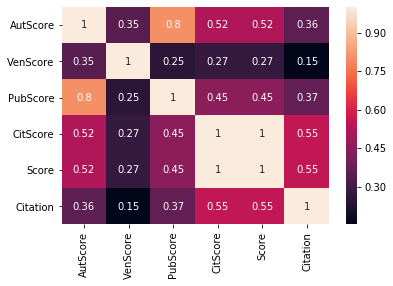

In [22]:
%time Index.generateQualitativeResults(PublicationInfoCSV, PublicationRankCSV, metaData, corrF, gridF)

In [23]:
%time Index.generateComparison(metaData, PublicationInfoCSV, DOItestPkl, True)

FileNotFoundError: [Errno 2] No such file or directory: '../COM/1985metadata2020.pkl'

In [24]:
%time Index.generateQuantitativeResults (VenueInfoCSV, metaData, citNet, PublicationGraph, PublicationHash, AuthorInfoCSV, PublicationInfoCSV, DOItestPkl)

FileNotFoundError: [Errno 2] No such file or directory: '../COM/1985metadata2020.pkl'

In [29]:
%time Index.generateBaseline (citNetFull, DOIPkl, DOItestPkl)

refs in Bibliographic Coupling Top 0 0
refs in Cocited list Top 1000 137
Wall time: 54.3 s
